In [ ]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [1]:
import gym
import numpy as np

In [2]:
env = gym.make('CartPole-v1')

In [3]:
from functools import wraps

In [4]:
from gym import Wrapper

In [5]:
from gym import wrappers

# Take random steps and check how far we proceed

In [6]:
total_episodes_random_steps = 1000
steps_in_episode = []

In [7]:
rewards_in_episode = []

In [8]:
for episode in range(total_episodes_random_steps):
    steps = 0
    done = False
    reward_this_ep = 0
    
    env.reset()
    
    while not done:
    #take a random step: there are only two actions possible: step of 0 or 1
        new_state, reward, done, info = env.step(np.random.randint(2))
        reward_this_ep += 1
    
        if not done:
            steps += 1
        else:
            steps_in_episode.append(steps)
            rewards_in_episode.append(reward_this_ep)
            break

In [9]:
import matplotlib.pyplot as plt

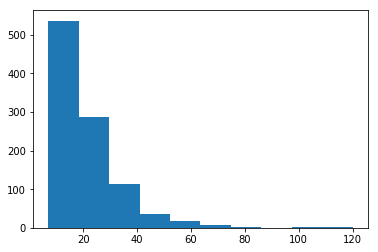

In [10]:
plt.hist(steps_in_episode)
plt.show()

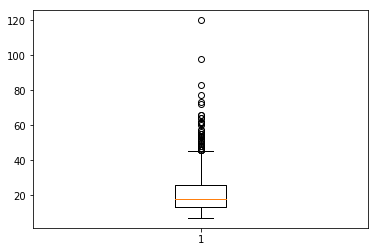

In [11]:
plt.boxplot(steps_in_episode)
plt.show()

# In the random steps scenario, the median is ~20; 50 p.c ~30; 99 p.c ~42

https://github.com/openai/gym/wiki/CartPole-v0
<br>

Type: Box(4)
<br>
<br>Num	Observation	Min	Max
<br>0	Cart Position	-2.4	2.4
<br>1	Cart Velocity	-Inf	Inf
<br>2	Pole Angle	~ -41.8°	~ 41.8°
<br>3	Pole Velocity At Tip	-Inf	Inf
<br>Actions

#as seen in <br>
https://medium.com/@_seanavery/reinforcement-learning-for-n00bs-pt-1-23ca71fc3c  and <br>
https://ferdinand-muetsch.de/cartpole-with-qlearning-first-experiences-with-openai-gym.html <br>
the cart position can be ignored and we focus on the pole angle and velocity alone

In [12]:
#we will create a discrete set of observations; basically rounding off our inputs to some values and make it discrete

bins = np.zeros((4,10))<br>
<br>	bins[0] = np.linspace(-4.8, 4.8, 10)
<br>	bins[1] = np.linspace(-5, 5, 10)
<br>	bins[2] = np.linspace(-.418, .418, 10)
<br>	bins[3] = np.linspace(-5, 5, 10)

In [13]:
np.linspace(-0.418, 0.418, 10)

array([-0.418     , -0.32511111, -0.23222222, -0.13933333, -0.04644444,
        0.04644444,  0.13933333,  0.23222222,  0.32511111,  0.418     ])

In [14]:
#create different buckets for the pos and velocity
def fn_pole_angle_bucketing(input_val):
    
    output_val = None
    if (input_val >= -0.418) and (input_val < -0.325):
        output_val = 1
    elif (input_val >= -0.325) and (input_val < -0.232):
        output_val = 2
    elif (input_val >= -0.232) and (input_val < -0.139):
        output_val = 3
    elif  (input_val >= -0.139) and (input_val < -0.046):
        output_val = 4
    elif (input_val >= -0.046) and (input_val < 0.046):
        output_val = 5
    elif (input_val >= 0.046) and (input_val < 0.0139):
        output_val = 6
    
    elif (input_val >= 0.139) and (input_val < 0.232):
        output_val = 7
    
    elif (input_val >= 0.232) and (input_val < 0.325):
        output_val = 8
    elif (input_val >= 0.325) and (input_val < 0.418):
        output_val = 9
    else:
        output_val = 0
    
    return output_val

In [15]:
np.linspace(-5, 5, 10)

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ])

In [16]:
#create different buckets for the pos and velocity
def fn_pole_vel_bucketing(input_val):
    
    output_val = None
    if (input_val >= -5) and (input_val < -3.9):
        output_val = 1
    elif (input_val >= -3.9) and (input_val < -2.8):
        output_val = 2
    elif (input_val >= -2.8) and (input_val < -1.7):
        output_val = 3
    elif  (input_val >= -1.7) and (input_val < -0.55):
        output_val = 4
    elif (input_val >= -0.55) and (input_val < 0.055):
        output_val = 5
    elif (input_val >= 0.55) and (input_val < 1.7):
        output_val = 6
    
    elif (input_val >= 1.7) and (input_val < 2.8):
        output_val = 7
    
    elif (input_val >= 2.8) and (input_val < 3.9):
        output_val = 8
    elif (input_val >= 3.9) and (input_val < 5):
        output_val = 9
    else:
        output_val = 0
    
    
    return output_val

In [17]:
def fn_discrete_bins_pole_ang_pole_vel(input_box):
    
    cart_pos, cart_vel, pole_angle, pole_vel= input_box[0], input_box[1], input_box[2], input_box[3]
    #print(cart_pos, cart_vel, pole_angle, pole_vel)
    
    #cart_pos_str = str(fn_pos_output_1_to_9(cart_pos))
    #cart_vel_str = str(fn_output_0_to_6(cart_vel))
    pole_angle_str = str(fn_pole_angle_bucketing(pole_angle))
    pole_vel_str = str(fn_pole_vel_bucketing(pole_vel))

    combined_str = pole_angle_str + pole_vel_str
    
    return combined_str

In [18]:
q_table_map = {}

In [19]:
index_val = 0
for a in range(0, 10):
    for b in range(0, 10):
        q_key = str(a)+ str(b)
        q_table_map[q_key] = index_val
        index_val += 1

In [20]:
len(q_table_map)

100

In [21]:
q_table = np.zeros((len(q_table_map), 2))

In [22]:
import random

In [23]:
#params
learning_rate = 0.5
gamma = 0.9

In [24]:
# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.01             # Exponential decay rate for exploration prob

In [25]:
total_episodes = 10000


for episode in range(total_episodes):
    state = env.reset()
    #action = env.action_space.sample()
    done = False
    cnt = 0
    
    while not done:
        cnt += 1
        str_rep_of_state = fn_discrete_bins_pole_ang_pole_vel(state)
        index_val_of_state = q_table_map[str_rep_of_state]
        
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(q_table[index_val_of_state,:])
        
        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        
        if done and cnt < 200:
            reward = -300
        
        
        #Q[s,a] = Q[s, a] + learning rate * (reward + gamma * np.max(Q[new_state, :]) - Q[s, a])
        
        str_rep_of_new_state = fn_discrete_bins_pole_ang_pole_vel(new_state)
        index_val_of_new_state = q_table_map[str_rep_of_new_state]
        
        q_table[index_val_of_state, action] = q_table[index_val_of_state, action] + learning_rate * (reward + gamma * (np.max(q_table[index_val_of_new_state, :])) - q_table[index_val_of_state, action])
        
        action = np.argmax(q_table[index_val_of_new_state, :])
        state = new_state
        
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

In [26]:
np.sum(q_table)

-13509.107257643534

In [27]:
state = env.reset()
done = False
total_reward = 0
count = 0

while not done:

    str_rep_of_state = fn_discrete_bins_pole_ang_pole_vel(state)
    index_val_of_state = q_table_map[str_rep_of_state]
    
    action = np.argmax(q_table[index_val_of_state, :])

    new_state, reward, done, info = env.step(action)

    total_reward += reward

    state = new_state
    
print(total_reward)

232.0


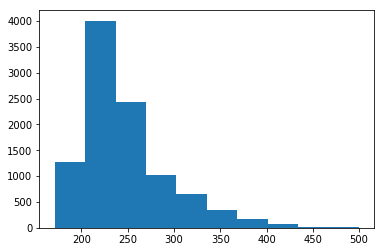

In [28]:
total_reward_list = []
for i in range(total_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    count = 0

    while not done:
        #reverse 
        str_rep_of_state = fn_discrete_bins_pole_ang_pole_vel(state)
        index_val_of_state = q_table_map[str_rep_of_state]

        action = np.argmax(q_table[index_val_of_state, :])

        new_state, reward, done, info = env.step(action)

        total_reward += reward
        state = new_state
    total_reward_list.append(total_reward)
        
plt.hist(total_reward_list)
plt.show()

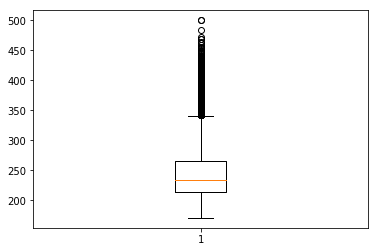

In [29]:
plt.boxplot(total_reward_list)
plt.show()

# With Q-learning, everything is 500 steps!!

In [ ]:
np.average(total_reward_list)

In [ ]:
import os

In [ ]:
os.getcwd()

In [ ]:
env = wrappers.Monitor(env, 'C:\\Users\\shenbaga.kumar\\Documents\\cartpole-experiment-1')

In [ ]:
env = gym.wrappers.Monitor(env, "./vid", video_callable=lambda episode_id: True,force=True)

In [ ]:
total_reward_list = []
for i in range(10):
    state = env.reset()
    done = False
    total_reward = 0
    count = 0

    while not done:
        #reverse 
        str_rep_of_state = fn_discrete_bins_pole_ang_pole_vel(state)
        index_val_of_state = q_table_map[str_rep_of_state]

        action = np.argmax(q_table[index_val_of_state, :])

        new_state, reward, done, info = env.step(action)

        total_reward += reward
        state = new_state
    total_reward_list.append(total_reward)

In [ ]:
env.close()

# Try a very simple Q table with only pole angle binned

In [ ]:
def fn_discrete_bins_pole_ang_only(input_box):
    
    cart_pos, cart_vel, pole_angle, pole_vel= input_box[0], input_box[1], input_box[2], input_box[3]
    #print(cart_pos, cart_vel, pole_angle, pole_vel)
    
    #cart_pos_str = str(fn_pos_output_1_to_9(cart_pos))
    #cart_vel_str = str(fn_output_0_to_6(cart_vel))
    
    pole_angle_str = str(fn_pole_angle_bucketing(pole_angle))
    
    #pole_vel_str = str(fn_pole_vel_bucketing(pole_vel))

    combined_str = pole_angle_str# + pole_vel_str
    
    return combined_str

In [ ]:
q_table_map2 = {}

In [ ]:
index_val = 0
for a in range(0, 10):
    q_key = str(a)
    q_table_map2[q_key] = index_val
    index_val += 1

In [ ]:
q_table2 = np.zeros((len(q_table_map2), 2))

In [ ]:
env2 = gym.make('CartPole-v1')

In [ ]:
env2.reset()

In [ ]:
total_episodes = 10000


for episode in range(total_episodes):
    state = env2.reset()
    #action = env.action_space.sample()
    done = False
    cnt = 0
    
    while not done:
        cnt += 1
        str_rep_of_state = fn_discrete_bins_pole_ang_only(state)
        index_val_of_state = q_table_map2[str_rep_of_state]
        
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(q_table2[index_val_of_state,:])
        
        # Else doing a random choice --> exploration
        else:
            action = env2.action_space.sample()
        
        new_state, reward, done, info = env2.step(action)
        
        if done and cnt < 200:
            reward = -300
        
        
        #Q[s,a] = Q[s, a] + learning rate * (reward + gamma * np.max(Q[new_state, :]) - Q[s, a])
        
        str_rep_of_new_state = fn_discrete_bins_pole_ang_only(new_state)
        index_val_of_new_state = q_table_map2[str_rep_of_new_state]
        
        q_table2[index_val_of_state, action] = q_table2[index_val_of_state, action] + learning_rate * (reward + gamma * (np.max(q_table2[index_val_of_new_state, :])) - q_table2[index_val_of_state, action])
        
        action = np.argmax(q_table2[index_val_of_new_state, :])
        state = new_state
        
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

In [ ]:
state = env2.reset()
done = False
total_reward = 0
count = 0

while not done:
    print(state)
    str_rep_of_state = fn_discrete_bins_pole_ang_only(state)
    index_val_of_state = q_table_map2[str_rep_of_state]
    
    action = np.argmax(q_table2[index_val_of_state, :])
    print(action)
    new_state, reward, done, info = env2.step(action)

    total_reward += reward

    state = new_state
    
print(total_reward)

# we see that using only the pole angle is not working. We need to use both pole angle and pole vel